# **ZERO-NOISE EXTRAPOLATION**

---

*   Based on: [Qiskit: Noise Models](https://qiskit.github.io/qiskit-aer/apidocs/aer_noise.html)







In [ ]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-ibm-experiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit.visualization import plot_histogram
from qiskit_ibm_experiment import IBMExperimentService
from qiskit.quantum_info import Operator
from scipy.optimize import curve_fit

**1.- Build a simple noise model with depolarizing noise**



> This part first create a noise model by adding a depolarized error.








In [25]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx']


**2.- Create different circuits to test your noise models and choose the observable to measure**


*   Greenberger–Horne–Zeilin (GHZ) circuit



In [ ]:
# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])
print(circ)

     ┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2 


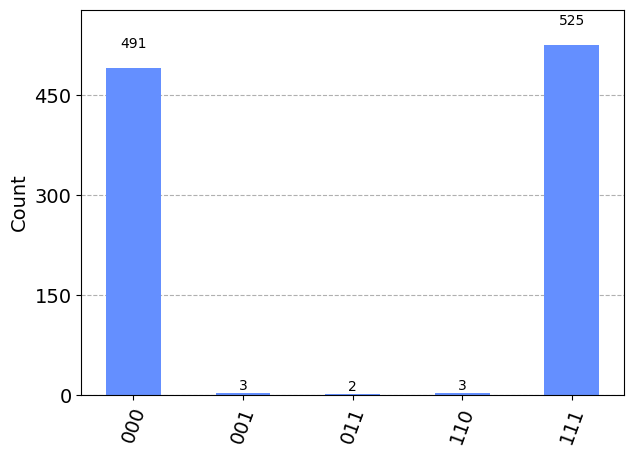

In [ ]:
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)




*    Bell state circuit



In [ ]:
# Circuit to create a Bell state
bell_circ = QuantumCircuit(2, 2)
bell_circ.h(0)
bell_circ.cx(0, 1)
bell_circ.measure([0, 1], [0, 1])
print(bell_circ)

     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


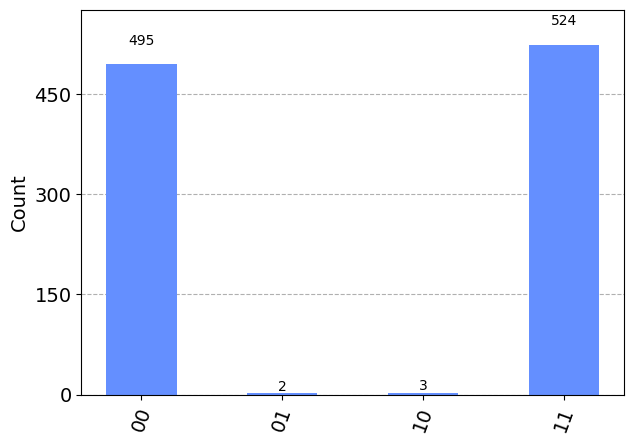

In [ ]:
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       basis_gates=basis_gates)
transpiled_circuit = transpile(bell_circ, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)

**3.- Apply the unitary folding method.**


In [ ]:
def fold_circuit(circuit, fold_factor=1):
    """
    Applies a simple unitary folding by repeating the entire circuit.
    fold_factor: Number of times the original circuit is repeated.
    """
    folded_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)
    for _ in range(fold_factor + 1):  # fold_factor + 1 to include the original
        for inst, qargs, cargs in circuit.data:
            folded_circuit.append(inst, qargs, cargs)

    return folded_circuit

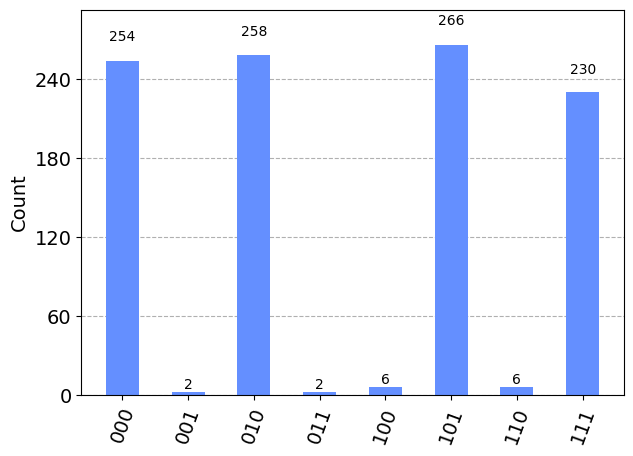

In [ ]:
fold_factor = 1  # Adjust fold_factor based on desired level of folding
folded_circ = fold_circuit(circ, fold_factor=fold_factor)

# Continue with the simulation using folded_circ instead of circ
transpiled_folded_circuit = transpile(folded_circ, backend)


result = backend.run(transpiled_folded_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)

**4.- Apply the extrapolation method:**


*   Linear




In [ ]:
# Function for linear extrapolation
def linear_fit(x, a, b):
    return a * x + b

# Run the circuit with different fold_factors and store the counts
fold_factors = [1, 2, 3]  # Example fold factors, you can choose more or different factors
results = []


for factor in fold_factors:
    folded_circ = fold_circuit(circ, fold_factor=factor)
    transpiled_folded_circuit = transpile(folded_circ, backend)
    result = backend.run(transpiled_folded_circuit).result()
    counts = result.get_counts(0)
    results.append(counts)

In [ ]:
# Assume that we are interested in the probability of the '000' outcome
# Convert counts to probabilities
probabilities = []
for counts in results:
    total_counts = sum(counts.values())
    print(counts)
    prob_000 = counts.get('000', 0) / total_counts
    probabilities.append(prob_000)

{'100': 2, '110': 3, '001': 6, '101': 248, '010': 257, '000': 227, '011': 6, '111': 275}
{'001': 123, '100': 133, '111': 128, '011': 120, '110': 126, '101': 132, '010': 144, '000': 118}
{'101': 130, '100': 103, '000': 139, '010': 118, '011': 141, '111': 136, '110': 136, '001': 121}


In [ ]:
# Fit the probabilities to the linear model
fold_factors = np.array(fold_factors, dtype=float)  # Convert fold factors to a numpy array for fitting
probabilities = np.array(probabilities, dtype=float)  # Convert probabilities to a numpy array for fitting

# Perform the linear fit
params, covariance = curve_fit(linear_fit, fold_factors, probabilities)
print(params)

# Extrapolated zero-noise probability
zero_noise_prob = params[1]

print(f"Extrapolated zero-noise probability for '000': {zero_noise_prob}")

[-0.04296875  0.24348958]
Extrapolated zero-noise probability for '000': 0.2434895833316817


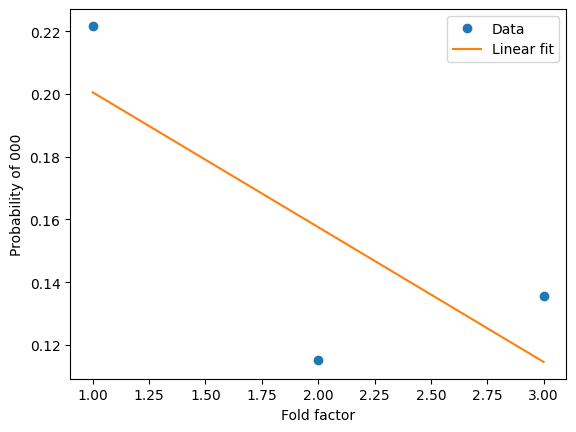

In [ ]:
# Plotting the results for visualization
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fold_factors, probabilities, 'o', label='Data')
plt.plot(fold_factors, linear_fit(fold_factors, *params), '-', label='Linear fit')
plt.xlabel('Fold factor')
plt.ylabel('Probability of 000')
plt.legend()
plt.show()



*   Polynomial



In [ ]:
# Fit the probabilities to a polynomial model
degree = 2  # Degree of the polynomial model
coeffs = np.polyfit(fold_factors, probabilities, degree)

# Create a polynomial function from the fitted coefficients
poly_func = np.poly1d(coeffs)

# Extrapolated zero-noise probability using the polynomial model
# For extrapolation to zero-noise (fold factor = 0), we evaluate the polynomial function at 0
zero_noise_prob_poly = poly_func(0)

print(f"Extrapolated zero-noise probability for '000' (Polynomial): {zero_noise_prob_poly}")

Extrapolated zero-noise probability for '000' (Polynomial): 0.45507812500000044


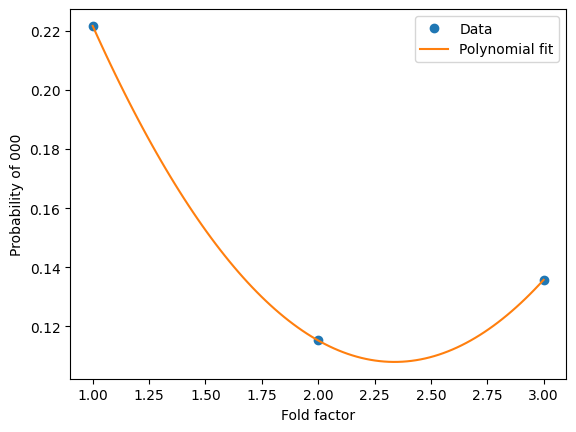

In [ ]:
# Plotting the results for visualization
fold_factors_extended = np.linspace(min(fold_factors), max(fold_factors), 100)  # Extended fold factors for smooth plotting
plt.figure()
plt.plot(fold_factors, probabilities, 'o', label='Data')
plt.plot(fold_factors_extended, poly_func(fold_factors_extended), '-', label='Polynomial fit')
plt.xlabel('Fold factor')
plt.ylabel('Probability of 000')
plt.legend()
plt.show()



*   Exponential



In [26]:
# Fit the probabilities to the exponential model, with increased maxfev, adjusted p0, and parameter bounds
params, covariance = curve_fit(
    exponential_fit,
    fold_factors,
    probabilities,
    maxfev=5000  # Increase the number of function evaluations
)

# Extract the parameters
a, b, c = params

# Extrapolated zero-noise probability using the exponential model
# We evaluate the exponential function at fold factor = 0
zero_noise_prob_exp = a * np.exp(-b * 0) + c

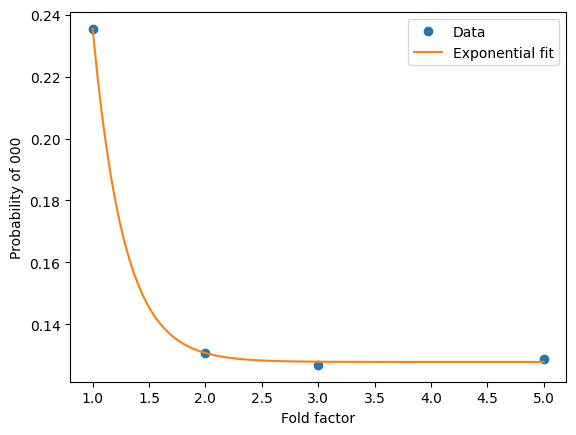

In [27]:
# Plotting the results for visualization
fold_factors_extended = np.linspace(min(fold_factors), max(fold_factors), 100)  # Extended fold factors for smooth plotting
plt.figure()
plt.plot(fold_factors, probabilities, 'o', label='Data')
plt.plot(fold_factors_extended, exponential_fit(fold_factors_extended, a, b, c), '-', label='Exponential fit')
plt.xlabel('Fold factor')
plt.ylabel('Probability of 000')
plt.legend()
plt.show()

{'001': 1, '100': 2, '110': 3, '011': 5, '111': 263, '010': 239, '000': 242, '101': 269}
{'011': 124, '111': 151, '110': 104, '010': 130, '000': 113, '101': 137, '001': 140, '100': 125}
{'100': 113, '011': 119, '111': 146, '010': 136, '000': 120, '001': 144, '110': 127, '101': 119}
{'101': 144, '001': 123, '110': 125, '100': 120, '010': 131, '000': 115, '111': 144, '011': 122}


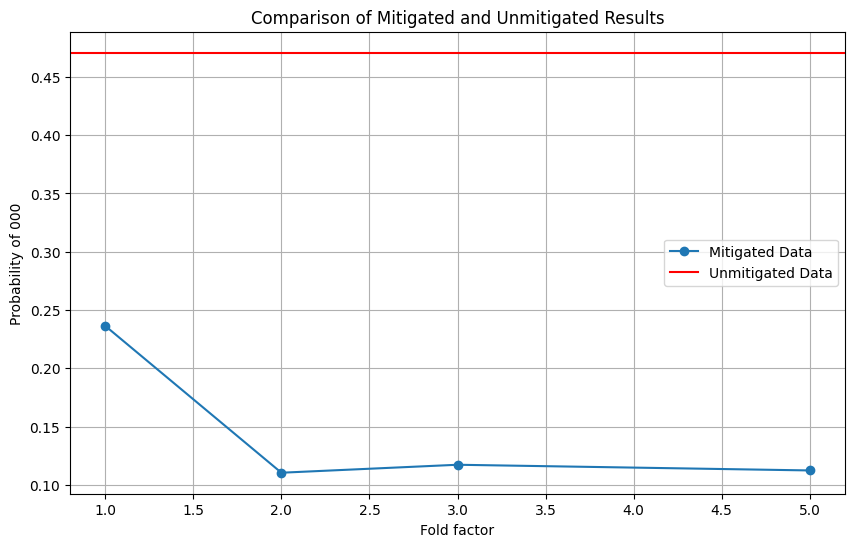

In [28]:
# Function to run simulation
def run_simulation(circuit, backend, noise_model, fold_factor=None):
    if fold_factor is not None:
        circuit = fold_circuit(circuit, fold_factor)
    transpiled_circuit = transpile(circuit, backend)
    result = backend.run(transpiled_circuit).result()
    return result.get_counts()

# Function to perform polynomial extrapolation
def polynomial_extrapolation(fold_factors, probabilities, degree):
    coeffs = np.polyfit(fold_factors, probabilities, degree)
    poly_func = np.poly1d(coeffs)
    return poly_func

# Run unmitigated simulation
unmitigated_counts = run_simulation(circ, backend, noise_model)

# Run mitigated simulations and perform polynomial extrapolation
fold_factors = [1, 2, 3, 5]  # Example fold factors
mitigated_results = []
for factor in fold_factors:
    mitigated_counts = run_simulation(circ, backend, noise_model, fold_factor=factor)
    print(mitigated_counts)
    mitigated_results.append(mitigated_counts)

# Convert counts to probabilities for '000' outcome
probabilities = [counts.get('000', 0) / sum(counts.values()) for counts in mitigated_results]

# Perform polynomial extrapolation
degree = 2  # Quadratic polynomial
poly_func = polynomial_extrapolation(fold_factors, probabilities, degree)

# Evaluate at zero-noise limit (fold factor = 0)
zero_noise_prob = poly_func(0)

# Plot unmitigated and extrapolated mitigated probabilities
plt.figure(figsize=(10, 6))
plt.plot(fold_factors, probabilities, 'o-', label='Mitigated Data')
plt.axhline(y=unmitigated_counts.get('000', 0) / sum(unmitigated_counts.values()), color='r', linestyle='-', label='Unmitigated Data')
plt.xlabel('Fold factor')
plt.ylabel('Probability of 000')
plt.legend()
plt.title('Comparison of Mitigated and Unmitigated Results')
plt.grid(True)
plt.show()